# MESCAL 102: Advanced Data Fetching Techniques

## Introduction

Building on the StudyManager fundamentals, this notebook demonstrates MESCAL's advanced data fetching and transformation capabilities. These techniques significantly streamline multi-scenario analysis by leveraging pandas' power while abstracting away common boilerplate code.

MESCAL's data handling utilities provide efficient ways to:
- Work with multi-index DataFrames from scenario and comparison collections
- Filter data using model properties
- Aggregate data across complex dimensions
- Combine scenarios and comparisons in unified analyses

## Setup

In [1]:
import os
import logging
import warnings
import pandas as pd
import pypsa
from IPython.display import Image
import plotly.express as px

from mescal import StudyManager
from mescal.utils.pandas_utils import flatten_df, prepend_model_prop_levels, filter_by_model_query
from mescal.utils.plotly_utils.plotly_theme import PlotlyTheme
from mescal_pypsa import PyPSADataset

# Directory setup
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

# Configuration for cleaner output
logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', 6)
pd.set_option('display.width', 1000)
PlotlyTheme().apply()

In [2]:
# Same study setup as in 101, only this time it's from a method so we can re-use it
from studies.study_01_intro_to_mescal.scripts.setup_study_manager import get_scigrid_de_study_manager

study = get_scigrid_de_study_manager()


## Working with Multi-Index DataFrames

Fetching data across multiple scenarios naturally creates multi-index DataFrames. Let's examine and transform these structures:

### Calculating Averages Per Scenario

In [3]:
df_price_change = study.comp.fetch('buses_t.marginal_price')
df_price_change_mean = df_price_change.mean().unstack('dataset')
print(df_price_change_mean)

dataset    solar_150 vs base  solar_200 vs base  wind_150 vs base  wind_200 vs base
Bus                                                                                
1                   0.210744           0.230623         -6.644124         -7.292750
10                  0.250483           0.214094         -6.220950         -8.214383
100                -0.712512          -1.279986         -1.500320         -3.403255
100_220kV          -0.717737          -1.288928         -1.496799         -3.412561
101                 0.144366           0.100898         -6.115556         -7.510163
...                      ...                ...               ...               ...
96_220kV           -0.173702          -0.405244         -4.028766         -4.810695
97                 -0.694532          -1.244591         -1.385540         -2.557227
98                  0.166729           0.132677         -6.155495         -7.608517
99                 -0.711075          -1.284553         -1.324793         -3

The result is a DataFrame showing the average price change per bus for each scenario comparison.

### Combining Scenarios and Comparisons

To analyze both raw values and deltas in one operation:

In [4]:
df_price_all = study.scen_comp.fetch('buses_t.marginal_price')
print(df_price_all.head())

type                 scenario                       ...       comparison                    
dataset                  base                       ... wind_200 vs base                    
Bus                         1        10        100  ...               98        99  99_220kV
snapshot                                            ...                                     
2011-01-01 00:00:00 -0.439753  5.772135  23.120287  ...        -1.818518  0.104774  0.108749
2011-01-01 01:00:00 -0.578449  6.100599  22.531275  ...        -2.017386 -0.806122 -0.815207
2011-01-01 02:00:00 -0.582087  6.071084  22.106222  ...        -2.007054 -2.256636 -2.262590
2011-01-01 03:00:00 -0.596210  6.139415  21.498113  ...        -2.147870 -3.477572 -3.480850
2011-01-01 04:00:00 -0.609622  6.164469  20.391625  ...        -2.151701 -5.055950 -5.051421

[5 rows x 5265 columns]


This DataFrame contains both the scenario data and comparison data, distinguished by the 'type' level in the MultiIndex.

### Unified Analysis

We can perform operations on this unified structure:

In [5]:
df_price_all_mean = df_price_all.mean().droplevel('type').unstack('dataset').sort_index(axis=1)
print(df_price_all_mean)

dataset         base  solar_150  solar_150 vs base  ...  wind_150 vs base   wind_200  wind_200 vs base
Bus                                                 ...                                               
1           7.676257   7.887001           0.210744  ...         -6.644124   0.383507         -7.292750
10         10.994609  11.245092           0.250483  ...         -6.220950   2.780226         -8.214383
100        21.880995  21.168483          -0.712512  ...         -1.500320  18.477740         -3.403255
100_220kV  21.977638  21.259901          -0.717737  ...         -1.496799  18.565077         -3.412561
101         8.245265   8.389631           0.144366  ...         -6.115556   0.735102         -7.510163
...              ...        ...                ...  ...               ...        ...               ...
96_220kV   13.212272  13.038570          -0.173702  ...         -4.028766   8.401577         -4.810695
97         21.288071  20.593539          -0.694532  ...         -1.385540

This creates a table with average prices and deltas side by side, sorted alphabetically by dataset name.

## Integrating Model Data with Time Series

A powerful MESCAL capability is the integration of static model data with time series data.

### Accessing Model Data

In [6]:
buses_model_df = study.scen.get_dataset('base').fetch('buses')
print(buses_model_df)

           v_nom type          x  ...  ref                   location control_area
Bus                               ...                                             
1          220.0        9.522576  ...        POINT (9.52258 52.36041)     TenneTDE
2          380.0        9.113210  ...        POINT (9.11321 52.54385)     TenneTDE
3          380.0        9.389745  ...        POINT (9.38975 52.02631)     TenneTDE
4          380.0        9.125266  ...        POINT (9.12527 52.53826)     TenneTDE
5          380.0       10.366275  ...       POINT (10.36627 52.28465)     TenneTDE
...          ...  ...        ...  ...  ...                        ...          ...
404_220kV  220.0        8.232094  ...        POINT (8.23209 47.55614)   TransnetBW
413_220kV  220.0        8.673717  ...        POINT (8.67372 49.29044)   TransnetBW
421_220kV  220.0        9.091835  ...        POINT (9.09184 49.29462)   TransnetBW
450_220kV  220.0        7.416708  ...        POINT (7.41671 51.45705)      Amprion
458_

### Filtering by Model Properties

Let's filter our time series to include only high voltage buses (v_nom >= 380 kV):

In [7]:
filtered_price_df = filter_by_model_query(df_price_all, buses_model_df, 'v_nom >= 380')
print(filtered_price_df.head())

type                 scenario                       ...       comparison                    
dataset                  base                       ... wind_200 vs base                    
Bus                        10        100       101  ...               97        98        99
snapshot                                            ...                                     
2011-01-01 00:00:00  5.772135  23.120287  1.358870  ...        -1.095655 -1.818518  0.104774
2011-01-01 01:00:00  6.100599  22.531275  1.347486  ...         0.510926 -2.017386 -0.806122
2011-01-01 02:00:00  6.071084  22.106222  1.344766  ...        -1.208963 -2.007054 -2.256636
2011-01-01 03:00:00  6.139415  21.498113  1.376138  ...        -2.351651 -2.147870 -3.477572
2011-01-01 04:00:00  6.164469  20.391625  1.405119  ...        -5.122186 -2.151701 -5.055950

[5 rows x 2592 columns]


The `filter_by_model_query` utility applies pandas query syntax to filter time series based on model properties.

### Prepending Model Properties

We can add model properties as additional index levels:

In [8]:
price_with_control_area = prepend_model_prop_levels(filtered_price_df, buses_model_df, 'control_area')
print(price_with_control_area.head())

control_area          50Hertz    Amprion   50Hertz  ...         TenneTDE          50Hertz          Amprion
type                 scenario   scenario  scenario  ...       comparison       comparison       comparison
dataset                  base       base      base  ... wind_200 vs base wind_200 vs base wind_200 vs base
Bus                        10        100       101  ...               97               98               99
snapshot                                            ...                                                   
2011-01-01 00:00:00  5.772135  23.120287  1.358870  ...        -1.095655        -1.818518         0.104774
2011-01-01 01:00:00  6.100599  22.531275  1.347486  ...         0.510926        -2.017386        -0.806122
2011-01-01 02:00:00  6.071084  22.106222  1.344766  ...        -1.208963        -2.007054        -2.256636
2011-01-01 03:00:00  6.139415  21.498113  1.376138  ...        -2.351651        -2.147870        -3.477572
2011-01-01 04:00:00  6.164469  20.391

This operation adds the 'control_area' property from the bus model as a new level in our multi-index DataFrame.

### Aggregating by Model Properties

Now we can efficiently aggregate by control area:

In [9]:
price_by_control_area = price_with_control_area.mean().groupby(level=['control_area', 'dataset']).mean().unstack('control_area')
print(price_by_control_area)

control_area         50Hertz    Amprion   TenneTDE  TransnetBW
dataset                                                       
base               11.657645  18.804042  15.284996   23.333147
solar_150          11.628050  18.179100  14.830030   22.741469
solar_150 vs base  -0.029595  -0.624942  -0.454965   -0.591678
solar_200          11.448025  17.720580  14.463570   22.177620
solar_200 vs base  -0.209620  -1.083462  -0.821425   -1.155527
wind_150            7.087738  16.973092  12.332776   22.664264
wind_150 vs base   -4.569907  -1.830950  -2.952220   -0.668883
wind_200            4.765799  15.546364  10.669218   21.040701
wind_200 vs base   -6.891846  -3.257678  -4.615778   -2.292446


## Sophisticated Visualization Example

Let's demonstrate these techniques with a more sophisticated visualization. We'll create a boxplot showing the distribution of hourly prices by control area and scenario:

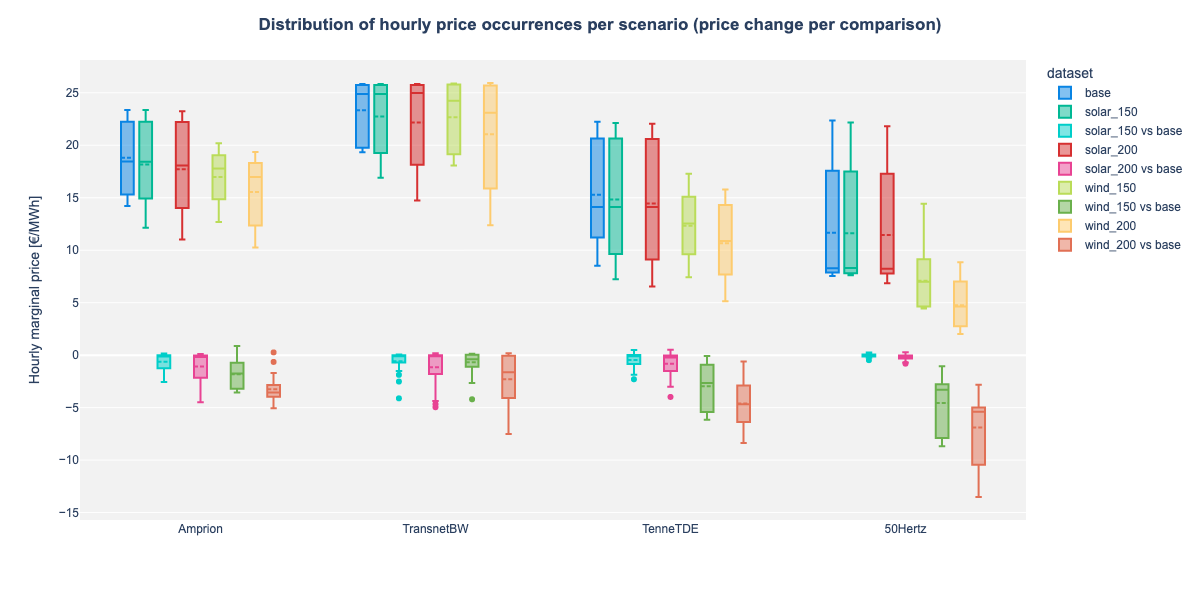

In [10]:
buses_model_df = study.scen.get_dataset('base').fetch('buses')
data = study.scen_comp.fetch('buses_t.marginal_price')
data = filter_by_model_query(data, buses_model_df, query='v_nom >= 380')
data = prepend_model_prop_levels(data, buses_model_df, 'control_area')
data = data.T.groupby(level=['dataset', 'control_area']).mean().T
data_flat = flatten_df(data)
fig = px.box(
    data_frame=data_flat,
    x='control_area',
    color='dataset',
    y='value',
    category_orders={'control_area': ['Amprion', 'TransnetBW', 'TenneTDE', '50Hertz']},
    labels={'value': 'Hourly marginal price [€/MWh]'},
)
fig.update_traces(boxmean=True)
fig.update_layout(title='<b>Distribution of hourly price occurrences per scenario (price change per comparison)</b>', width=1200)
fig.update_xaxes(title=None)


# Save and display the image (using this only so that the picture is shown on GitHub)
image_path = study.export_path('price_boxplot.png')
fig.update_layout(height=600, width=1200)
fig.write_image(image_path)
Image(image_path)

# fig.show()  # Use this instead when you are running locally and want to have full interactivity in the plot

## Advanced Transformation Pipeline

Let's trace through a complete data transformation pipeline that demonstrates MESCAL's efficiency:

In [12]:
# Start with raw data
df_raw = study.scen_comp.fetch('buses_t.marginal_price')

# Filter to high voltage buses
buses_model_df = study.scen.get_dataset('base').fetch('buses')
df_filtered = filter_by_model_query(df_raw, buses_model_df, 'v_nom >= 380')

# Add control area information
df_with_areas = prepend_model_prop_levels(df_filtered, buses_model_df, 'control_area')

# Calculate hourly area prices
hourly_area_prices = df_with_areas.T.groupby(['dataset', 'control_area']).mean().T.unstack()

# Reshape for analysis
area_price_stats = hourly_area_prices.groupby(['dataset', 'control_area']).agg(['mean', 'std', 'min', 'max'])

print(area_price_stats)

                                     mean       std        min        max
dataset           control_area                                           
base              50Hertz       11.657645  4.898477   7.536946  22.367118
                  Amprion       18.804042  3.200822  14.203696  23.352252
                  TenneTDE      15.284996  4.839524   8.528858  22.238178
                  TransnetBW    23.333147  2.799360  19.340758  25.851732
solar_150         50Hertz       11.628050  4.882195   7.616330  22.173180
                  Amprion       18.179100  3.853877  12.146565  23.361021
                  TenneTDE      14.830030  5.304740   7.223666  22.119134
                  TransnetBW    22.741469  3.428135  16.896716  25.850474
solar_150 vs base 50Hertz       -0.029595  0.171920  -0.479044   0.261827
                  Amprion       -0.624942  0.918766  -2.567606   0.157824
                  TenneTDE      -0.454965  0.770981  -2.298001   0.484883
                  TransnetBW    -0.591

What would normally take dozens of lines of data manipulation code is condensed into a few expressive operations that maintain the relationships between different types of data.

## Key Takeaways

- **Unified Analysis**: Work with scenarios and comparisons in the same analytical framework
- **Model and Time-Series Data Fetching**: Unified framework for fetching model and time-series data
- **Useful Integration Utilities**: MESCAL provides tools like `filter_by_model_query` and `prepend_model_prop_levels` that efficiently establish relationships between model properties and time series data and provide frequently needed filtering and property mapping features

These capabilities make MESCAL particularly powerful for complex multi-scenario analyses that would otherwise require extensive custom code.